In [3]:
import sys
import glob,os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

# Study of three class classification with variational model
## Goal: disentangle AGNs, crap and other non-SN like events from SN
For this I am looking if varaitional uncertainties/probabilities are a good indicator.

Exploring which variational 2 vs. 3 class is better doing this.

## 3 class variational

In [4]:
model_name = "variational_S_0_CLF_3_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07"
pred_dir = f'../dumps/real/clump/models/'
pred_file = f'{pred_dir}/{model_name}/PRED_{model_name}_aggregated.pickle'
df_pred = pd.read_pickle(pred_file)

FileNotFoundError: [Errno 2] No such file or directory: '../dumps/real/clump/models//variational_S_0_CLF_3_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07/PRED_variational_S_0_CLF_3_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07_aggregated.pickle'

In [5]:
plt.hist(df_pred['all_class0_std'],histtype='step',density=True,label="class 0")
plt.hist(df_pred['all_class1_std'],histtype='step',density=True,label="class 1")
plt.hist(df_pred['all_class2_std'],histtype='step',density=True,label="class 2")
plt.xlabel("std")
plt.legend()
plt.title("Uncertainty distribution predictions w. variational 3 class")

NameError: name 'df_pred' is not defined

### intersection of high uncertainty sample?
uncertainty for all classes is high for the same subsset of lcs? if so this could be a good indicator of OOD events

In [6]:
def plot_venn(df1,df2,colname,df1name,df2name):
    from matplotlib_venn import venn2
    fig = plt.figure()
    venn2(
        [
            set(df1[colname].values
                ),
            set(
                df2[colname].values
            )
        ], (df1name, df2name))
    plt.show()

In [7]:
d0 = df_pred[df_pred['all_class0_std']>0.1]
d1 = df_pred[df_pred['all_class1_std']>0.1]
d2 = df_pred[df_pred['all_class2_std']>0.1]
plot_venn(d0, d1, 'SNID',"class0>.1","class1>.1")
plot_venn(d0, d2, 'SNID',"class0>.1","class2>.1")
plot_venn(d1, d2, 'SNID',"class1>.1","class2>.1")

NameError: name 'df_pred' is not defined

### correlation probability vs. uncertainty

In [8]:
from scipy.stats import gaussian_kde
for i in [0,1,2]:
    df_sel = df_pred[df_pred[f"all_class{i}_std"]>.1]
    x= df_sel[f'all_class{i}_median']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'median {i}')
    plt.ylabel(f'std {i}')
    plt.show()

NameError: name 'df_pred' is not defined

### are these uncertainties/probs correlated with #ml epochs or other OOD indicators?

In [9]:
# get header info to see corrrelations
from astropy.table import Table
path_des_data = os.environ.get("DES_DATA")
raw_dir = f"{path_des_data}/DESALL_forcePhoto_real_snana_fits/"
list_files = glob.glob(os.path.join(f"{raw_dir}", "*HEAD.FITS"))
list_df_h = []
for f in list_files:
    header = Table.read(f, format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)
    list_df_h.append(df_header)
df_head = pd.concat(list_df_h, sort=True)

In [10]:
df = df_pred.merge(df_head,on='SNID')

NameError: name 'df_pred' is not defined

In [ ]:
# [k for k in df.keys()]

In [ ]:
for i in [0,1,2]:
    df_sel = df#df[df[f"all_class{i}_std"]>.1]
    x = df_sel['PRIVATE(DES_numepochs_ml)']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

In [ ]:
for i in [0,1,2]:
    df_sel = df#df[df[f"all_class{i}_std"]>.1]    
    x= df_sel['PRIVATE(DES_numepochs_ml)']
    y = df_sel[f'all_class{i}_median']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'mean {i}')
    plt.show()

### how about spectroscopically classified SNe?

In [ ]:
for i in [0,1,2]:
    df_sel = df
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_median'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_median'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_median'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'mean {i}')
    plt.show()

In [11]:
for i in [0,1,2]:
    df_sel = df
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

NameError: name 'df' is not defined

In [12]:
for i in [0,1,2]:
    df_sel = df
    plt.scatter(df[f'all_class{i}_median'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia[f'all_class{i}_median'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa[f'all_class{i}_median'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN[f'all_class{i}_median'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.ylabel(f'std {i}')
    plt.xlabel(f'mean {i}')
    plt.show()

NameError: name 'df' is not defined

In [13]:
df_sel = df
plt.scatter(df[f'all_class1_median'],df[f'all_class2_median'],c='gray')
df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
plt.scatter(df_Ia[f'all_class1_median'],df_Ia[f'all_class2_median'],c='green',s=100)
df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
plt.scatter(df_nonIa[f'all_class1_median'],df_nonIa[f'all_class2_median'],c='blue',s=100)
df_AGN = df_sel[df_sel['SNTYPE']==80]
plt.scatter(df_AGN[f'all_class1_median'],df_AGN[f'all_class2_median'],c='red',s=100)
plt.ylabel(f'mean 2')
plt.xlabel(f'mean 1')
plt.show()

NameError: name 'df' is not defined

In [14]:
df_sel = df
plt.scatter(df[f'all_class1_std'],df[f'all_class2_std'],c='gray')
df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
plt.scatter(df_Ia[f'all_class1_std'],df_Ia[f'all_class2_std'],c='green',s=100)
df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
plt.scatter(df_nonIa[f'all_class1_std'],df_nonIa[f'all_class2_std'],c='blue',s=100)
df_AGN = df_sel[df_sel['SNTYPE']==80]
plt.scatter(df_AGN[f'all_class1_std'],df_AGN[f'all_class2_std'],c='red',s=100)
plt.ylabel(f'std 2')
plt.xlabel(f'std 1')
plt.show()

NameError: name 'df' is not defined

## summary 3 class variational
Very bad news: AGNs have high probability of class 1 with low-uncertainty
To see if other crappy events are taken off, need to plot_lcs (see .py for this)

In [15]:
plt.close()

# class 2 variational

In [16]:
model_name = "variational_S_0_CLF_2_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07"
pred_dir = f'../dumps/real/clump/models/'
pred_file = f'{pred_dir}/{model_name}/PRED_{model_name}_aggregated.pickle'
df_pred = pd.read_pickle(pred_file)

Text(0.5,1,'Uncertainty distribution predictions w. variational 3 class')

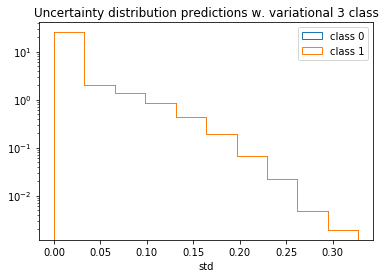

In [17]:
plt.hist(df_pred['all_class0_std'],histtype='step',density=True,label="class 0")
plt.hist(df_pred['all_class1_std'],histtype='step',density=True,label="class 1")
plt.xlabel("std")
plt.yscale("log")
plt.legend()
plt.title("Uncertainty distribution predictions w. variational 3 class")

sample interesection

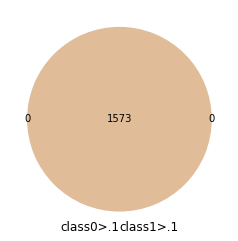

In [18]:
d0 = df_pred[df_pred['all_class0_std']>0.1]
d1 = df_pred[df_pred['all_class1_std']>0.1]
plot_venn(d0, d1, 'SNID',"class0>.1","class1>.1")

### correlation prob uncertainty

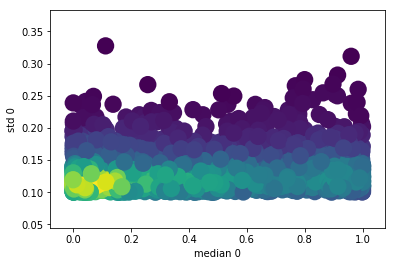

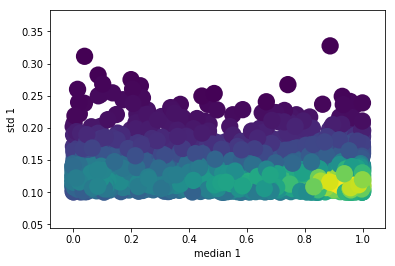

In [19]:
for i in [0,1]:
    df_sel = df_pred[df_pred[f"all_class{i}_std"]>.1]
    x= df_sel[f'all_class{i}_median']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'median {i}')
    plt.ylabel(f'std {i}')
    plt.show()

In [20]:
# get header info to see corrrelations
from astropy.table import Table
path_des_data = os.environ.get("DES_DATA")
raw_dir = f"{path_des_data}/DESALL_forcePhoto_real_snana_fits/"
list_files = glob.glob(os.path.join(f"{raw_dir}", "*HEAD.FITS"))
list_df_h = []
for f in list_files:
    header = Table.read(f, format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)
    list_df_h.append(df_header)
df_head = pd.concat(list_df_h, sort=True)

In [21]:
df = df_pred.merge(df_head,on="SNID")

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'SNID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


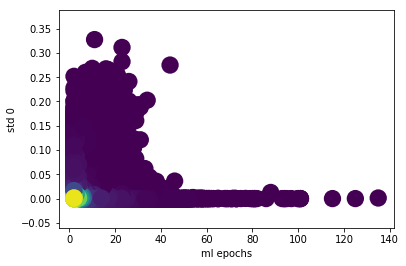

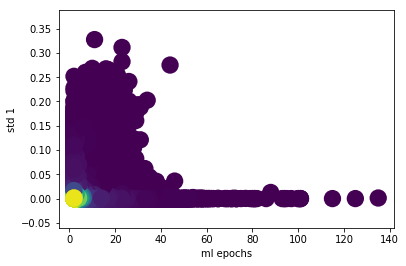

In [22]:
for i in [0,1]:
    df_sel = df#df[df[f"all_class{i}_std"]>.1]
    x = df_sel['PRIVATE(DES_numepochs_ml)']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

spectroscopically classified events

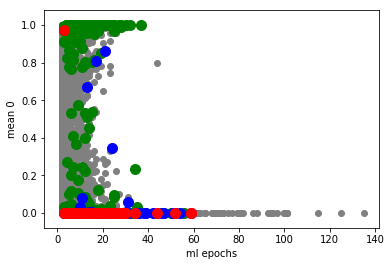

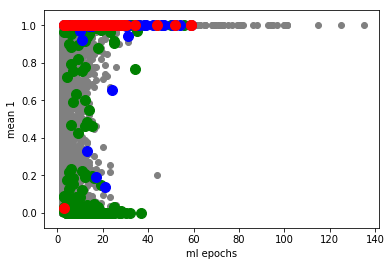

In [23]:
for i in [0,1]:
    df_sel = df
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_median'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_median'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_median'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_median'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'mean {i}')
    plt.show()

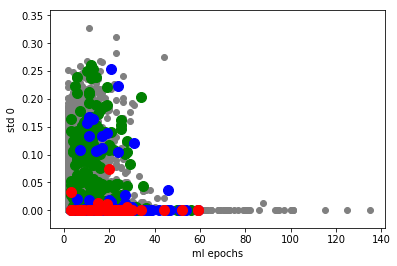

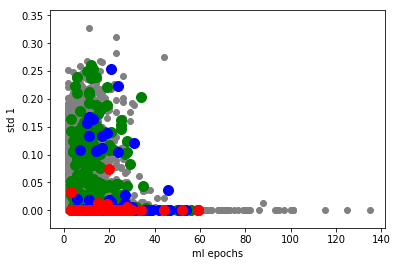

In [24]:
for i in [0,1]:
    df_sel = df
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

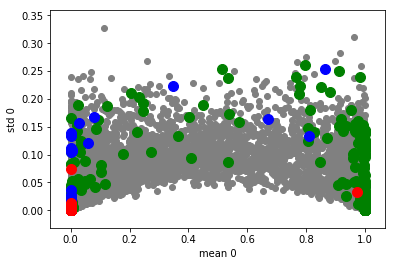

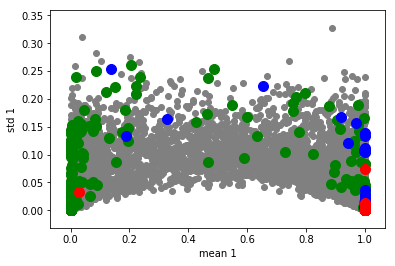

In [25]:
for i in [0,1]:
    df_sel = df
    plt.scatter(df[f'all_class{i}_median'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia[f'all_class{i}_median'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa[f'all_class{i}_median'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN[f'all_class{i}_median'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.ylabel(f'std {i}')
    plt.xlabel(f'mean {i}')
    plt.show()

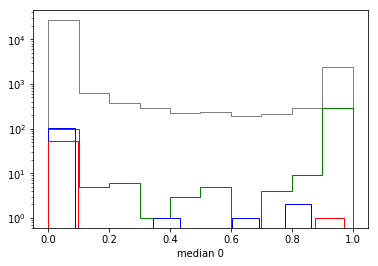

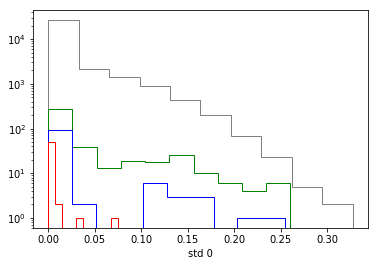

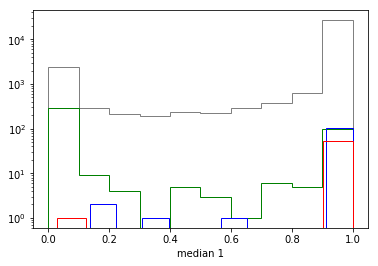

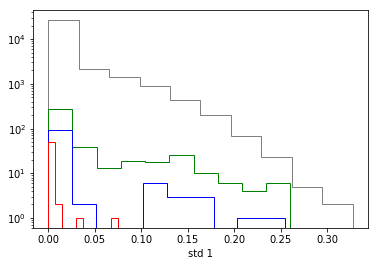

In [26]:
for c in [0,1]:
    
    plt.hist(df[f'all_class{c}_median'],histtype='step',color='grey')
    plt.hist(df_Ia[f'all_class{c}_median'],histtype='step',color='green')
    plt.hist(df_nonIa[f'all_class{c}_median'],histtype='step',color='blue')
    plt.hist(df_AGN[f'all_class{c}_median'],histtype='step',color='red')
    plt.yscale('log')
    plt.xlabel(f'median {c}')
    plt.show()
    
    plt.hist(df[f'all_class{c}_std'],histtype='step',color='grey')
    plt.hist(df_Ia[f'all_class{c}_std'],histtype='step',color='green')
    plt.hist(df_nonIa[f'all_class{c}_std'],histtype='step',color='blue')
    plt.hist(df_AGN[f'all_class{c}_std'],histtype='step',color='red')
    plt.yscale('log')
    plt.xlabel(f'std {c}')
    plt.show()

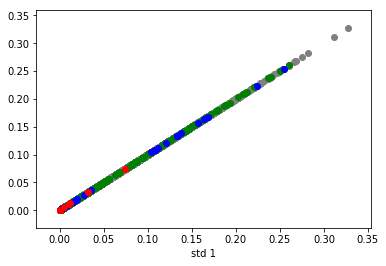

In [27]:
# std0 seems = std1, weird? maybe not since it is p1=1-p0
plt.scatter(df[f'all_class0_std'],df[f'all_class1_std'],color='grey')
plt.scatter(df_Ia[f'all_class0_std'],df_Ia[f'all_class1_std'],color='green')
plt.scatter(df_nonIa[f'all_class0_std'],df_nonIa[f'all_class1_std'],color='blue')
plt.scatter(df_AGN[f'all_class0_std'],df_AGN[f'all_class1_std'],color='red')
plt.xlabel(f'std 0')
plt.xlabel(f'std 1')
plt.show()

## Summary class 2 variational
same bad news... we should look at 7 types

# class7 variational

In [31]:
model_name = "variational_S_0_CLF_7_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07"
pred_dir = f'../dumps/real/clump/models/'
pred_file = f'{pred_dir}/{model_name}/PRED_{model_name}_aggregated.pickle'
print(pred_file)
df_pred = pd.read_pickle(pred_file)

../dumps/real/clump/models//variational_S_0_CLF_7_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07/PRED_variational_S_0_CLF_7_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.01_128_True_mean_C_WD_1e-07_aggregated.pickle


In [ ]:
for i in range(0,7):
    plt.hist(df_pred[f'all_class{i}_std'],histtype='step',density=True,label=f"class {i}")
plt.xlabel("std")
plt.yscale("log")
plt.legend()
plt.title("Uncertainty distribution predictions w. variational 7 class")

In [ ]:
d={}
for i in range(0,7):
    d[i] = df_pred[df_pred[f'all_class{i}_std']>0.1]
plot_venn(d[0], d[1], 'SNID',"class0>.1","class1>.1")
plot_venn(d[1], d[2], 'SNID',"class1>.1","class2>.1")
plot_venn(d[2], d[3], 'SNID',"class2>.1","class3>.1")
plot_venn(d[3], d[4], 'SNID',"class3>.1","class4>.1")
plot_venn(d[4], d[5], 'SNID',"class4>.1","class5>.1")
plot_venn(d[5], d[6], 'SNID',"class5>.1","class6>.1")
plot_venn(d[1], d[6], 'SNID',"class1>.1","class6>.1")

In [ ]:
for i in range(0,7):
    df_sel = df_pred[df_pred[f"all_class{i}_std"]>.1]
    x= df_sel[f'all_class{i}_median']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'median {i}')
    plt.ylabel(f'std {i}')
    plt.show()

In [120]:
# get header info to see corrrelations
from astropy.table import Table
path_des_data = os.environ.get("DES_DATA")
raw_dir = f"{path_des_data}/DESALL_forcePhoto_real_snana_fits/"
list_files = glob.glob(os.path.join(f"{raw_dir}", "*HEAD.FITS"))
list_df_h = []
for f in list_files:
    header = Table.read(f, format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)
    list_df_h.append(df_header)
df_head = pd.concat(list_df_h, sort=True)

In [127]:
df_pred["predicted_target"] = (df_pred[[k for k in df_pred.keys() if "all_class" in k and "median" in k]].idxmax(axis=1).str.strip("all_class").str.strip("_median").astype(int))
df = df_pred.merge(df_head,on="SNID")

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'SNID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


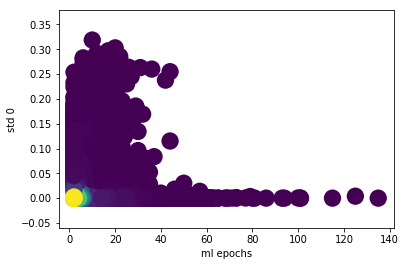

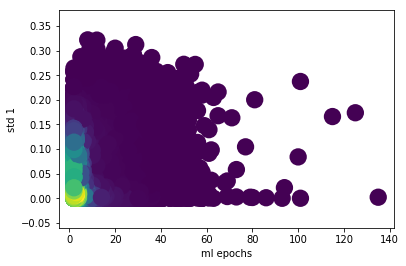

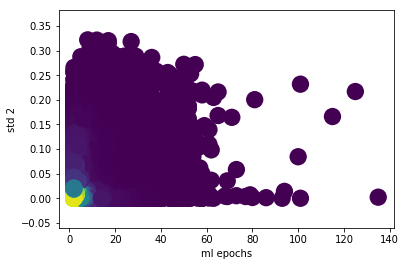

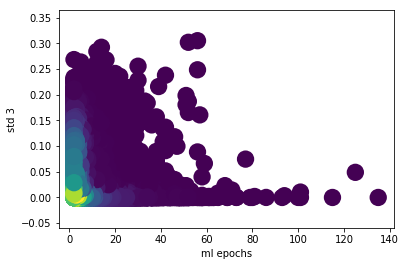

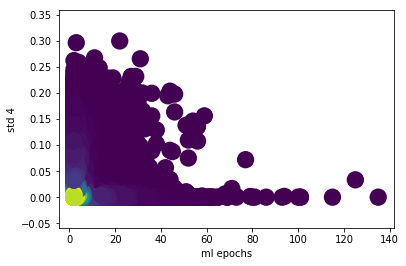

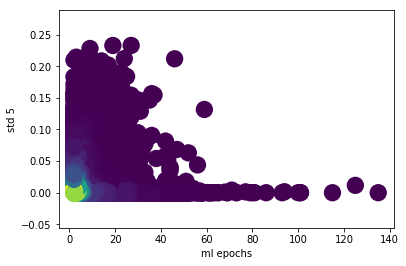

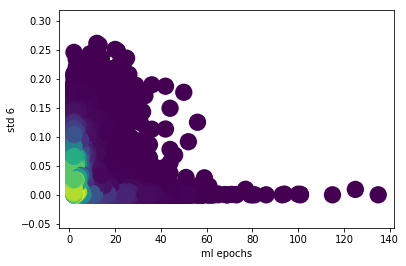

In [122]:
for i in range(0,7):
    df_sel = df#df[df[f"all_class{i}_std"]>.1]
    x = df_sel['PRIVATE(DES_numepochs_ml)']
    y = df_sel[f'all_class{i}_std']
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z, s=300,edgecolor='')
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

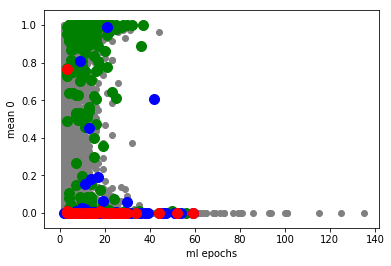

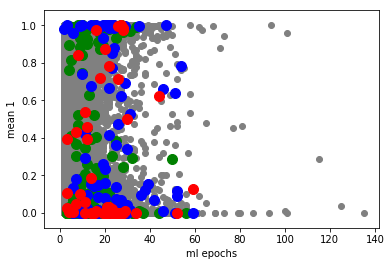

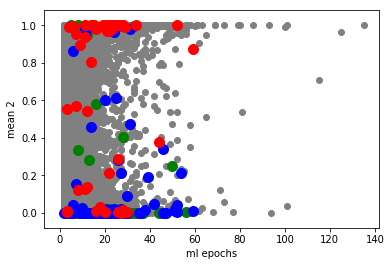

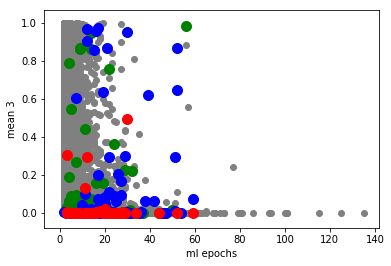

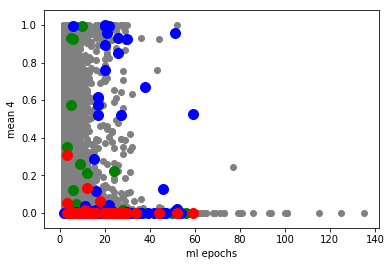

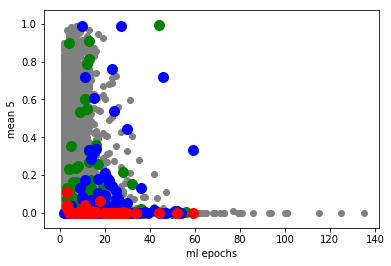

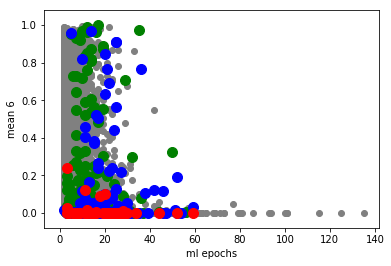

In [123]:
for i in range(0,7):
    df_sel = df
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_median'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_median'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_median'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_median'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'mean {i}')
    plt.show()

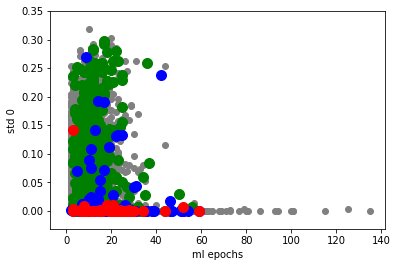

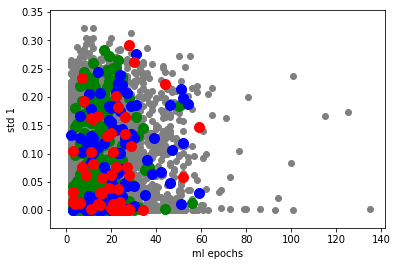

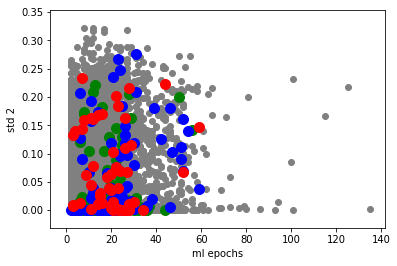

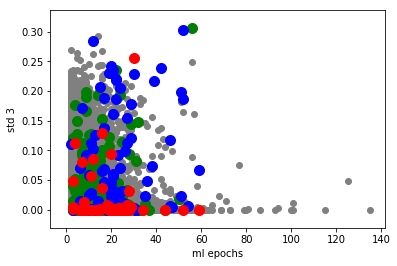

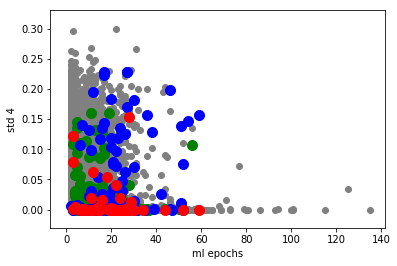

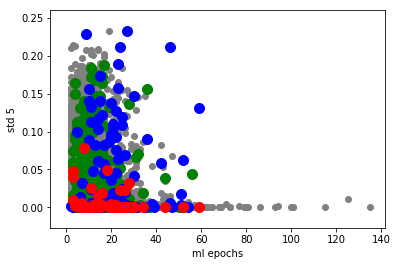

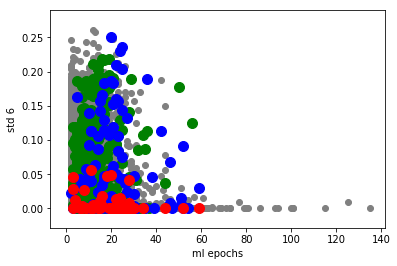

In [124]:
for i in range(0,7):
    df_sel = df
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

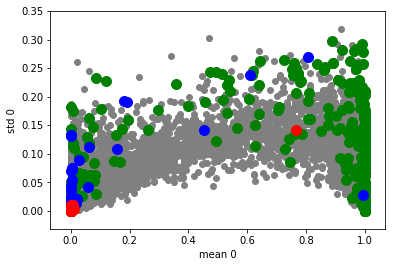

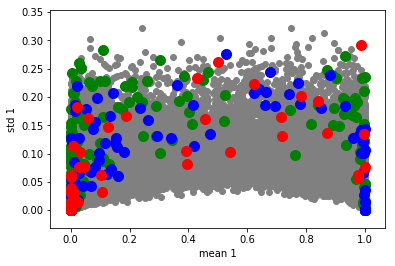

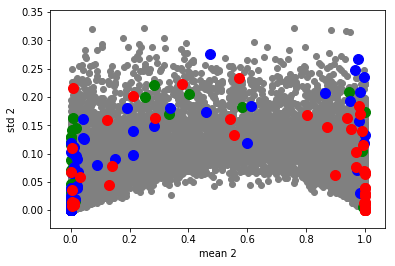

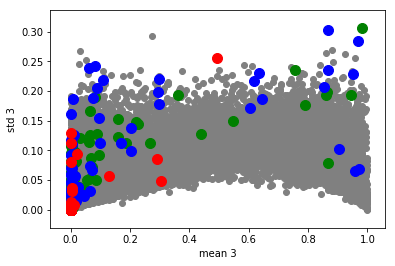

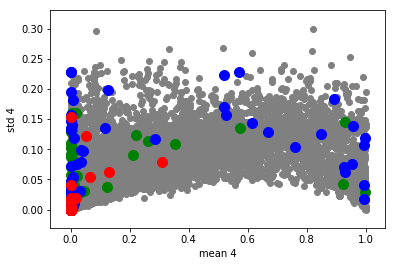

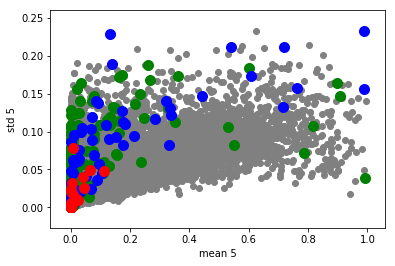

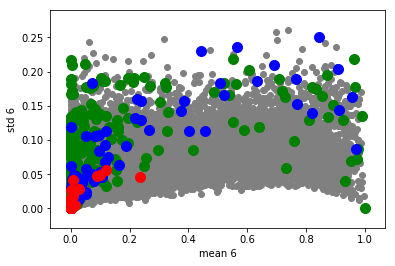

In [125]:
for i in range(0,7):
    df_sel = df
    plt.scatter(df[f'all_class{i}_median'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia[f'all_class{i}_median'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa[f'all_class{i}_median'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN[f'all_class{i}_median'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.ylabel(f'std {i}')
    plt.xlabel(f'mean {i}')
    plt.show()

AGNs have high probability for class 2 mostly, more than class 1. Some classified as type 2 but with std>0.1 may be eliminated.

lets see if this is true

In [136]:
df_sel = df[(df['predicted_target'] ==2) & (df['all_class2_std']>0.1) ]
print(len(df_sel[df_sel['SNTYPE']==80]),'from',len(df[df['SNTYPE']==80]))
print('doesnt look this promising')

12 from 53
doesnt look this promising


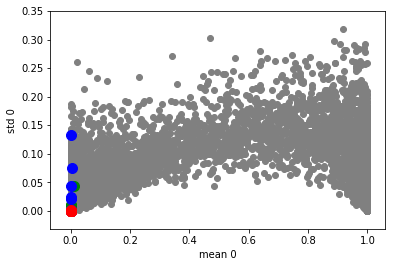

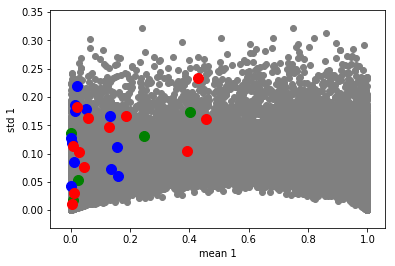

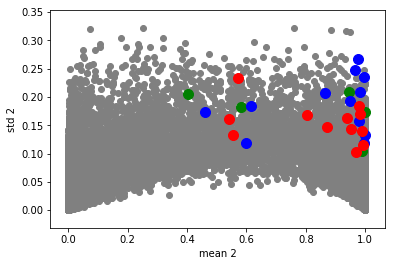

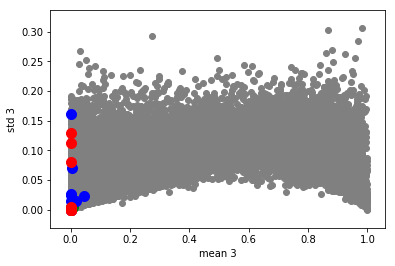

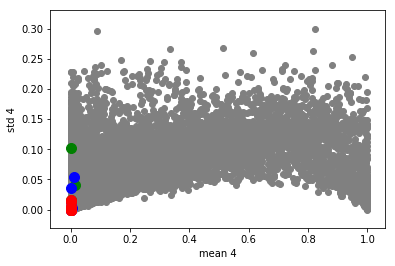

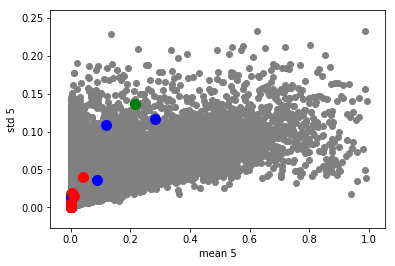

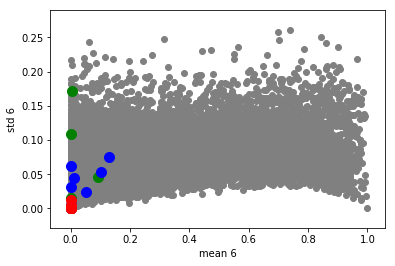

In [132]:
for i in range(0,7):
    plt.scatter(df[f'all_class{i}_median'],df[f'all_class{i}_std'],c='gray')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia[f'all_class{i}_median'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa[f'all_class{i}_median'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN[f'all_class{i}_median'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.ylabel(f'std {i}')
    plt.xlabel(f'mean {i}')
    plt.show()

In [138]:
for i in range(0,7):
    df_sel = df[(df['predicted_target'] ==i) ]
    print('class',i,":",len(df_sel[df_sel['SNTYPE']==80]),'from',len(df[df['SNTYPE']==80]))

class 0 : 1 from 53
class 1 : 14 from 53
class 2 : 37 from 53
class 3 : 0 from 53
class 4 : 1 from 53
class 5 : 0 from 53
class 6 : 0 from 53


In [141]:
print('high uncertainty classification')
for i in range(0,7):
    df_sel = df[(df['predicted_target'] ==i) & (df[f'all_class{i}_std']>0.1)]
    print('class',i,":",len(df_sel[df_sel['SNTYPE']==80]),'from',len(df[df['SNTYPE']==80]))

high uncertainty classification
class 0 : 1 from 53
class 1 : 10 from 53
class 2 : 12 from 53
class 3 : 0 from 53
class 4 : 0 from 53
class 5 : 0 from 53
class 6 : 0 from 53


 if i eliminate all those classified as type 2, and then those with type 1 with high-uncertainty only, most AGNs will be gone.

# Take 0 on an AGN free sample

In [164]:
#eliminate IIns
sample = df[ (df['predicted_target']!=2 ) ]
# elim inate high uncertainty type 1
sample = sample[ (sample['predicted_target']!=1) | ((sample['predicted_target']==1) & (sample[f'all_class1_std']<0.1)) ]

In [165]:
print('get',len(sample),'from',len(df))

get 21542 from 30157


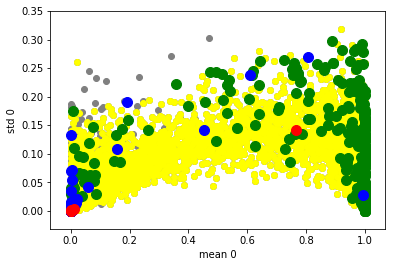

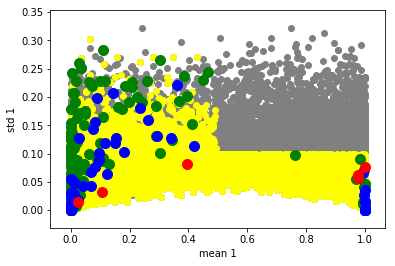

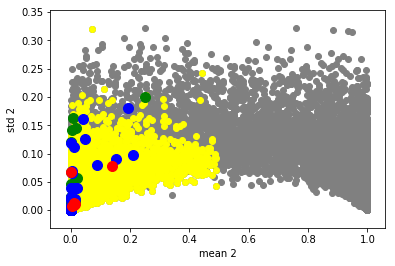

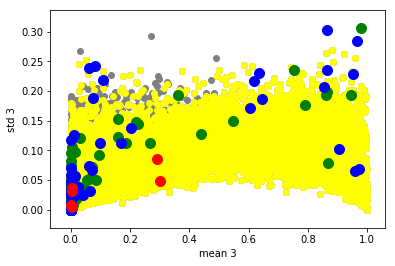

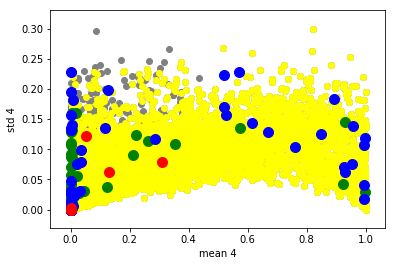

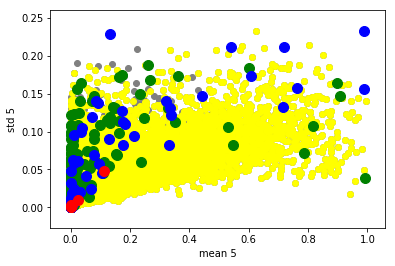

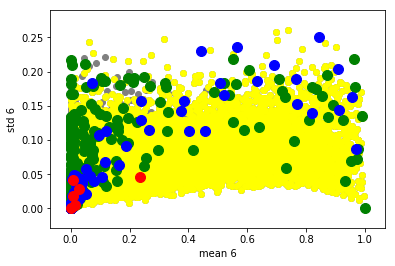

In [166]:
df_sel = sample
for i in range(0,7):
    plt.scatter(df[f'all_class{i}_median'],df[f'all_class{i}_std'],c='gray')
    plt.scatter(df_sel[f'all_class{i}_median'],df_sel[f'all_class{i}_std'],c='yellow')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia[f'all_class{i}_median'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa[f'all_class{i}_median'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN[f'all_class{i}_median'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.ylabel(f'std {i}')
    plt.xlabel(f'mean {i}')
    plt.show()

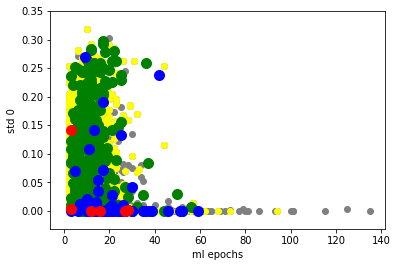

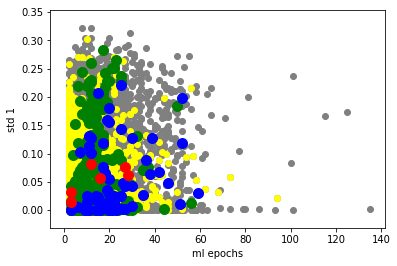

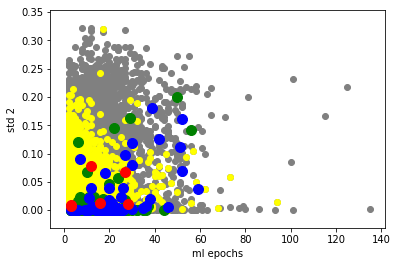

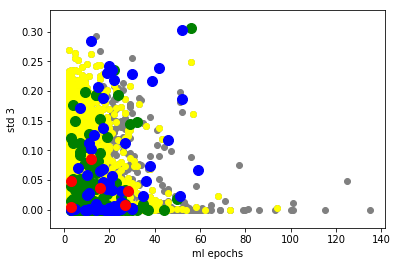

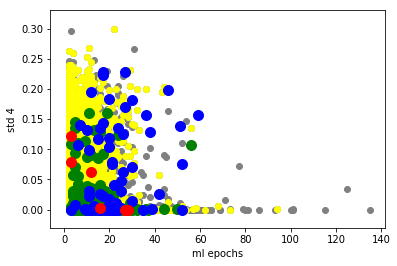

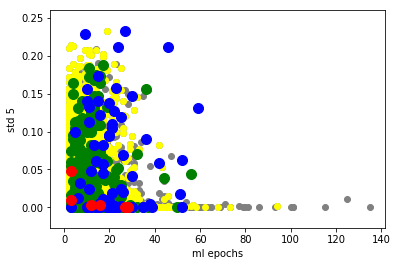

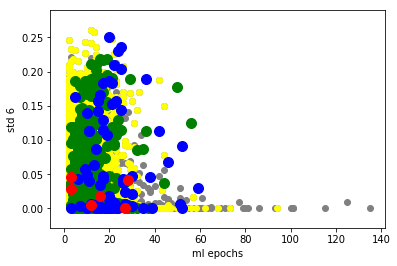

In [167]:
for i in range(0,7):
    plt.scatter(df['PRIVATE(DES_numepochs_ml)'],df[f'all_class{i}_std'],c='gray')
    plt.scatter(df_sel['PRIVATE(DES_numepochs_ml)'],df_sel[f'all_class{i}_std'],c='yellow')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_numepochs_ml)'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_numepochs_ml)'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_numepochs_ml)'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.xlabel(f'ml epochs')
    plt.ylabel(f'std {i}')
    plt.show()

sample doesnt like way too high ML epochs, thats good, but still faint correlation

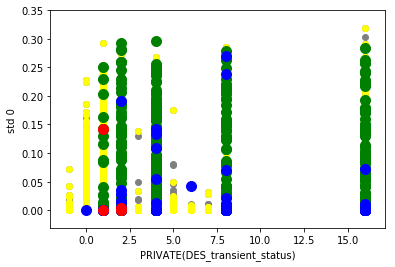

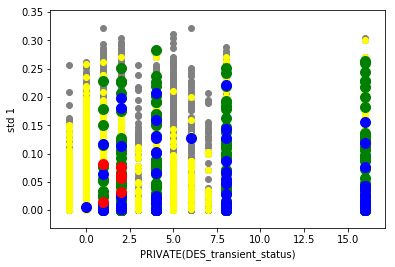

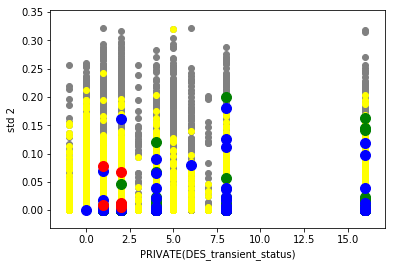

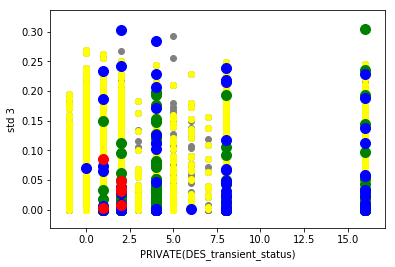

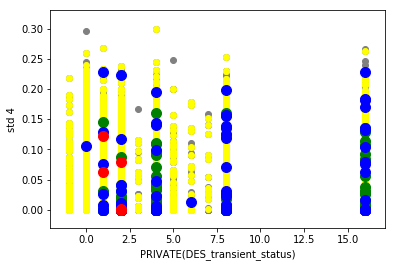

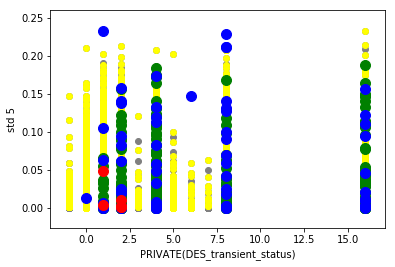

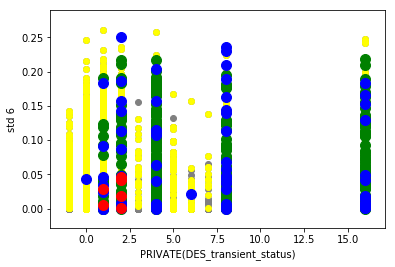

In [169]:
for i in range(0,7):
    plt.scatter(df['PRIVATE(DES_transient_status)'],df[f'all_class{i}_std'],c='gray')
    plt.scatter(df_sel['PRIVATE(DES_transient_status)'],df_sel[f'all_class{i}_std'],c='yellow')
    df_Ia = df_sel[(df_sel['SNTYPE']==1) | (df_sel['SNTYPE']==101)]
    plt.scatter(df_Ia['PRIVATE(DES_transient_status)'],df_Ia[f'all_class{i}_std'],c='green',s=100)
    df_nonIa = df_sel[(df_sel['SNTYPE']!=0) & (df_sel['SNTYPE']!=1) & (df_sel['SNTYPE']!=101) & (df_sel['SNTYPE']!=80) & (df_sel['SNTYPE']!=81)]
    plt.scatter(df_nonIa['PRIVATE(DES_transient_status)'],df_nonIa[f'all_class{i}_std'],c='blue',s=100)
    df_AGN = df_sel[df_sel['SNTYPE']==80]
    plt.scatter(df_AGN['PRIVATE(DES_transient_status)'],df_AGN[f'all_class{i}_std'],c='red',s=100)
    plt.xlabel('PRIVATE(DES_transient_status)')
    plt.ylabel(f'std {i}')
    plt.show()
    

!!! my sample has all transient status which could be bad

In [175]:
# some stats
print('sample size',len(sample))
print('spec Ia',len(sample[(sample['SNTYPE']==1) | (sample['SNTYPE']==101)]))
print('spec nonIa',len(sample[ (sample['SNTYPE']!=1) & (sample['SNTYPE']!=101) & (sample['SNTYPE']!=0) & (sample['SNTYPE']!=80) ]))
print('AGN',len(sample[sample['SNTYPE']==80]))

sample size 21542
spec Ia 367
spec nonIa 69
AGN 6


In [176]:
# from original
print('real size',len(df))
print('spec Ia',len(df[(df['SNTYPE']==1) | (df['SNTYPE']==101)]))
print('spec nonIa',len(df[ (df['SNTYPE']!=1) & (df['SNTYPE']!=101) & (df['SNTYPE']!=0) & (df['SNTYPE']!=80) ]))
print('AGN',len(df[df['SNTYPE']==80]))

real size 30157
spec Ia 409
spec nonIa 108
AGN 53
